# 第6章　使用图像描述符检索和搜索图像

## 检测Harris角点

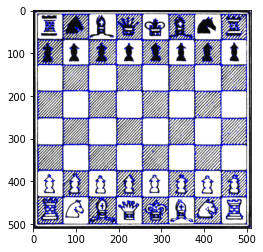

In [2]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("images/chess_board.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 2, , 0.04)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
plt.imshow(img)
plt.show()

## 检测DoG特征并提取SIFT描述符